In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.6 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#ML Libraries
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier
from xgboost import cv
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [9]:
train_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/training.csv"
test_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/test.csv"

In [10]:
#Import training and test data
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# Helper Functions

In [6]:
#Helper function to split data
def data_split(scaler_func, data, test_size=0.33):

  #Separate features from target
  X = data.drop('DiagPeriodL90D', axis = 1).values
  y = data['DiagPeriodL90D'].values

  #Scale and standardize the data
  #scaling
  scaler = scaler_func
  train = scaler.fit_transform(X)

  #Split data into training and test sets
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

  return X_train, X_val, y_train, y_val

#Helper functions that runs model and prints stats if get_stats=True
def run_model(scaler, data, clf, plot=False):

  X_train, X_val, y_train, y_val = data_split(scaler, data)
  model = clf
  model.fit(X_train,y_train)
  y_pred = model.predict(X_val)
  # Calculate and print individual metrics
  accuracy = accuracy_score(y_val,y_pred)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  f1 = f1_score(y_val, y_pred)

  if plot:
    model_stats(y_val, y_pred)

  return y_pred, accuracy, precision, recall, f1, auc

def model_cross_val(scaler_func, clf,data):

  #Separate features from target
  X = data.drop('DiagPeriodL90D', axis = 1).values
  y = data['DiagPeriodL90D'].values

  #Scale and standardize the data
  scaler = scaler_func
  train = scaler.fit_transform(X)

  kfold = KFold(n_splits=5)
  results = cross_val_score(clf, X, y, cv=kfold)
  return results.mean()

#Helper function that prints stats
def model_stats(y_val, y_pred):
  # Print confusion matrix
  print("Confusion Matrix:")
  print(confusion_matrix(y_val, y_pred))

  # Evaluate the model using classification report
  print("\nClassification Report:")
  print(classification_report(y_val, y_pred))

  print("\nIndividual Metrics:")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred))
  disp.plot()
  plt.show()

  # Calculate AUC
  auc = roc_auc_score(y_val, y_pred)
  print("AUC:", auc)

  # Plot ROC curve
  fpr, tpr, thresholds = roc_curve(y_val, y_pred)
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
  plt.plot([0, 1], [0, 1], 'k--', label='Random')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

def submit(y_test, test_encoded):
  y_submit = pd.DataFrame(y_test, columns=['DiagPeriodL90D'])
  submission = pd.concat([test_encoded['patient_id'], y_submit], axis=1)
  submission.to_csv("/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/result.csv")



# Obtain basic information about the dataset

In [11]:
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

Shape of training data set:  (12906, 83)
Shape of test data set:  (5792, 82)


In [12]:
#Remove columns where over half the values are null
null_values = pd.DataFrame(train.isna().sum(), columns=['null_vals']).reset_index()
null_values_sig = null_values[null_values['null_vals'] >= len(train)/2]

train = train.drop(null_values_sig['index'], axis='columns')
test = test.drop(null_values_sig['index'], axis='columns')
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

Shape of training data set:  (12906, 80)
Shape of test data set:  (5792, 79)


In [13]:
# Remove rows with more than 2 null values
train.drop(train[train.isnull().sum(axis=1)>2].index,axis=0,inplace=True)
print(train.shape)

(12823, 80)


In [14]:
#Redefine NaN payer type as no insurance info
train['payer_type'] = train['payer_type'].fillna('UNDEFINED')
test['payer_type'] = train['payer_type'].fillna('UNDEFINED')

In [15]:
train = train.drop(['patient_race', 'patient_gender'] , axis=1)
test = test.drop(['patient_race','patient_gender'] , axis=1)
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

(12823, 78)
(5792, 77)


In [16]:
# Separate training data into numerical and cateogrical features and fill missing values
numerical_cols = train.select_dtypes(exclude=['object']).columns
categorical_columns = train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = train[col].mode()[0]
        train[col].fillna(mode, inplace=True)
        test[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        mean = train[col].median()
        train[col].fillna(mean, inplace=True)
        test[col].fillna(mean, inplace=True)

# Encode categorical features

In this case, I used an ordinal encoder to test out a different encoding scheme

In [17]:
# Initialize the encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

for col in categorical_columns.to_list()+['patient_zip3']:
    # Fit the encoder on the training data
    encoder.fit(train[[col]])
    encoder.fit(test[[col]])
    # Transform both training and test data
    train[col] = encoder.transform(train[[col]])
    test[col] = encoder.transform(test[[col]])


In [18]:
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

Shape of training data set:  (12823, 78)
Shape of test data set:  (5792, 77)


## 3. Use Lasso Regression to identify important features

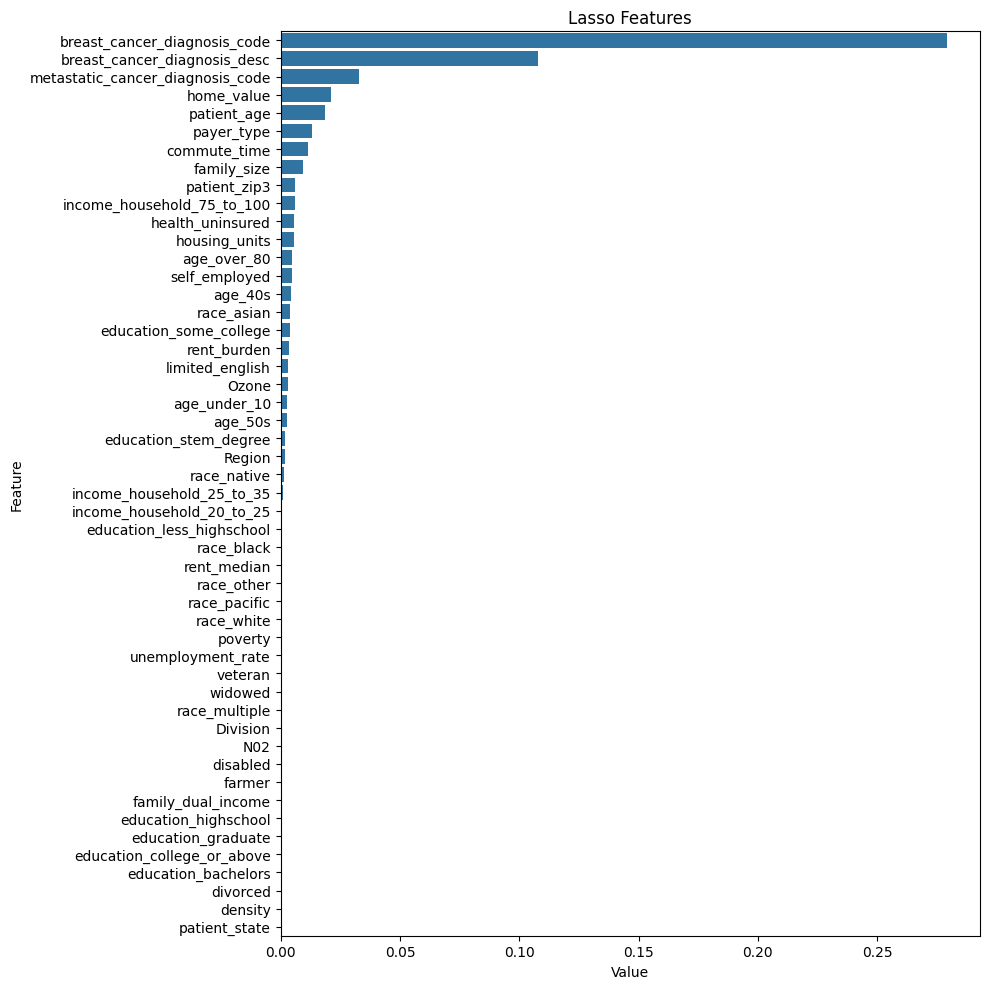

In [19]:
from sklearn.linear_model import LassoCV

y = train["DiagPeriodL90D"]
X_ = train.drop(["DiagPeriodL90D"],axis =1)

## Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X_)
cols = X_.columns

#Train a Lasso regressor
lasso = LassoCV().fit(X, y)
#Find important features
importance = np.abs(lasso.coef_)
#Feature names correspond with columns
feature_names = np.array(cols)

#Sort features by importaance
feat_ind = np.argsort(importance)[::-1]
#totlasso = 20
feature_imp = pd.DataFrame(columns=['Value','Feature'])
feature_imp.loc[:,'Value'] = importance
feature_imp.loc[:,'Feature'] = cols

feature_imp = pd.DataFrame(sorted(zip(importance, cols)), columns=['Value','Feature'])
data_feat = feature_imp.sort_values(by="Value", ascending=False)
#data_feat = data_feat.iloc[0:30, :]
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=data_feat[0:50])
plt.title('Lasso Features')
plt.tight_layout()
plt.show()

## Use top 20 features from the Lasso Regression

In [20]:
cols_20 = data_feat.Feature[0:20].to_list()
train_20 = pd.concat([train[cols_20], train['DiagPeriodL90D']], axis=1)
test_20 = test[cols_20]

In [21]:
#Separate features from target
X = train_20.drop('DiagPeriodL90D', axis = 1).values
y = train_20['DiagPeriodL90D'].values

#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# Use pipelining to run and compare multiple models

In [22]:
#Check which model works best
from sklearn.ensemble import RandomForestClassifier

pipelines = {}

LR_Pipeline = Pipeline([
               ('scaler', StandardScaler()),
               ('clf', LogisticRegression())
              ])
pipelines['LR'] = LR_Pipeline

XGBC_Pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', XGBClassifier(random_state=42))
              ])
pipelines['XGBClassifier'] = XGBC_Pipeline

RandomForest_Pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))
              ])
pipelines['RandomForest'] = RandomForest_Pipeline

Lightgbm_Pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LGBMClassifier())
              ])
pipelines['Lightgbm'] = Lightgbm_Pipeline

In [23]:
from datetime import datetime as dt
import time


for name, pipeline in pipelines.items():
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    print('model name: ', name)
    print('model classification runtime: ', end-start)


best_accuracy=0.0
best_classifier_name = 0

for name,model in pipelines.items():
    start = time.time()
    score = model.score(X_val, y_val)
    end = time.time()
    if score > best_accuracy:
        best_accuracy = score
        best_classifier_name = name

    print(f'''{name} Test Accuracy: {score}''')
    print('model inference runtime: ', end-start)

model name:  LR
model classification runtime:  0.06313848495483398
model name:  XGBClassifier
model classification runtime:  0.5831315517425537
model name:  RandomForest
model classification runtime:  2.3265328407287598
[LightGBM] [Info] Number of positive: 5336, number of negative: 3255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 8591, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621115 -> initscore=0.494284
[LightGBM] [Info] Start training from score 0.494284
model name:  Lightgbm
model classification runtime:  0.38655829429626465
LR Test Accuracy: 0.7793005671077504
model inference runtime:  0.002843618392944336
XGBClassifier Test Accuracy: 0.7818998109640832
model inference runtime:  0.02069687843322754
RandomForest Test Accuracy: 0.7828449905

### The LightGBM model works best, let's use grid search to optimize hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Test some parameters
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

grid = GridSearchCV(LGBMClassifier(), param_grid, refit = True, verbose = 3,  cv=StratifiedKFold(n_splits=3))

# fitting the model for grid search
grid.fit(X, y)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LGBMClassifier(),
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [31, 127], 'reg_alpha': [0.1, 0.5]},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'lambda_l1': 1.5, 'lambda_l2': 0, 'min_data_in_leaf': 400, 'num_leaves': 31, 'reg_alpha': 0.1}
LGBMClassifier(lambda_l1=1.5, lambda_l2=0, min_data_in_leaf=400, reg_alpha=0.1)


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
test_20 = scaler.fit_transform(test_20)

#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

model = LGBMClassifier(lambda_l1=1.5, lambda_l2=0, min_data_in_leaf=400, reg_alpha=0.1)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
# Calculate and print individual metrics
accuracy = accuracy_score(y_val,y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Info] Number of positive: 5336, number of negative: 3255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 8591, number of used fe

In [25]:
print(accuracy, precision, recall, f1)

0.8126181474480151 0.788988003691172 0.9599550898203593 0.8661151443525241


In [26]:
y_test = model.predict(test_20)
submit(y_test, test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
